In [1]:
# !pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD
import warnings

warnings.filterwarnings("ignore")

In [3]:
import kagglehub

path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


In [4]:
labels = ['Covid', 'Normal', 'Viral Pneumonia']
img_size = 224

def get_training_data(dataset_path):
    images = []  # List to hold image data
    labels_list = []  # List to hold class labels

    for label in labels:
        class_path = os.path.join(dataset_path, label)  # Path to each class folder

        for img in os.listdir(class_path):  # Iterate over each image in the folder
            try:
                img_arr = cv2.imread(os.path.join(class_path, img))  # Read image
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image
                images.append(resized_arr)  # Append image data
                labels_list.append(label)  # Append corresponding class label
            except Exception as e:
                print(f"Error loading image {img}: {e}")  # Print error if any issues occur

    # Convert to numpy arrays
    images = np.array(images)  # Images will have shape (-1, img_size, img_size, 3)
    labels_list = np.array(labels_list)  # Convert labels to numpy array
    return images, labels_list

In [5]:
train_dir = f'{path}/Covid19-dataset/train'
test_dir = f'{path}/Covid19-dataset/test'

x_train, y_train = get_training_data(train_dir)
x_test, y_test = get_training_data(test_dir)

In [6]:
# reshuffled our data
np.random.seed(42)
seed = 42

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]

test_indices = np.random.permutation(len(x_test))
x_test = x_test[test_indices]
y_test = y_test[test_indices]

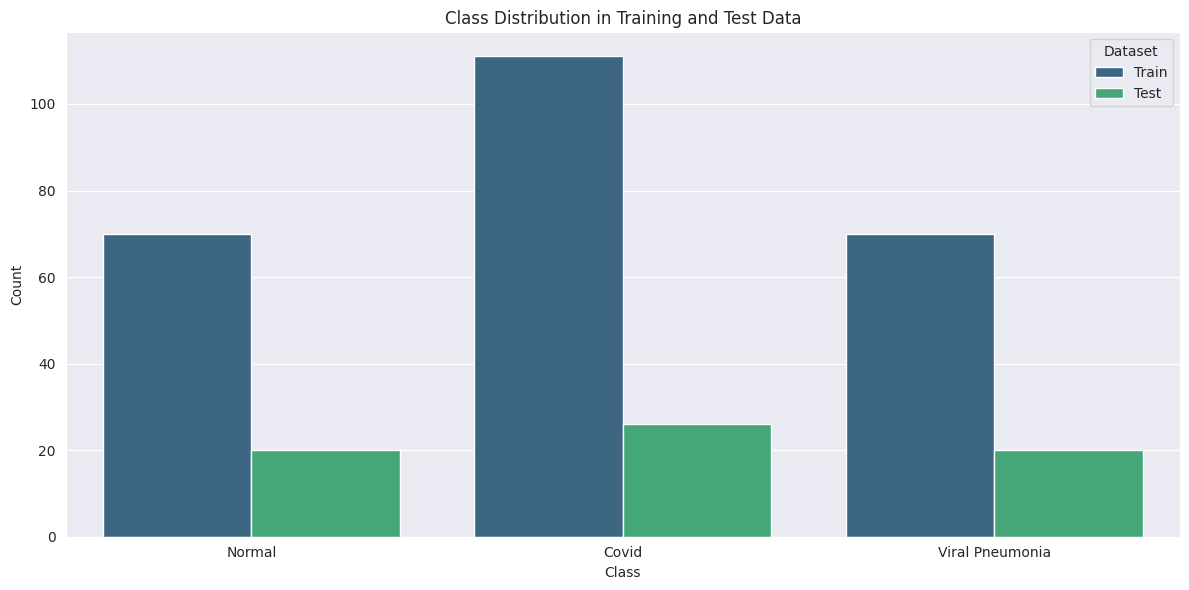

In [7]:
def show_combined_classes(y_train, y_test, class_names=None):
    # Create a DataFrame for combined data
    train_labels = ["Train"] * len(y_train)
    test_labels = ["Test"] * len(y_test)

    combined_data = pd.DataFrame({
        "Class": np.concatenate([y_train, y_test]),
        "Dataset": train_labels + test_labels
    })

    # Set consistent color palette
    sns.set_style('darkgrid')
    plt.figure(figsize=(12, 6))
    sns.countplot(data=combined_data, x="Class", hue="Dataset", palette="viridis")

    # Set plot labels and title
    plt.title("Class Distribution in Training and Test Data")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.legend(title="Dataset")

# Plot the combined graph
show_combined_classes(y_train, y_test)
plt.tight_layout()
plt.show()

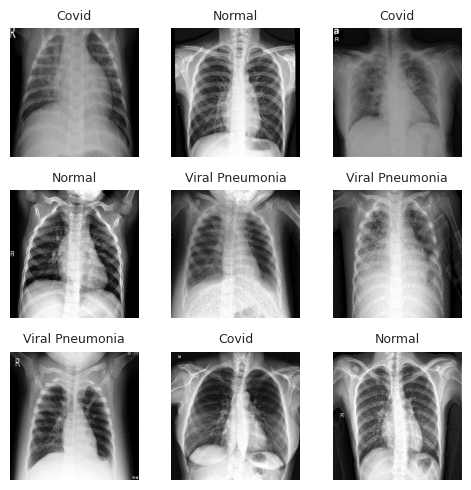

In [8]:
# Set the number of images to display
num_of_images = 9

# Create a single figure
plt.figure(figsize=(5, 5))

# Loop through the number of images and plot them
for index in range(1, num_of_images + 1):
    plt.subplot(3, 3, index)  # Create a 3x3 grid
    plt.imshow(x_train[index], cmap='gray_r')  # Display the image
    plt.title(f'{y_train[index]}', fontsize=9)  # Add the label as the title
    plt.axis('off')  # Turn off the axis for clarity

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [9]:
# Get the dimensions of the first image in the dataset
img_rows = x_train[0].shape[0]  # Height of the image
img_cols = x_train[0].shape[1]  # Width of the image

# Reshape the training and test datasets to include a channel dimension (3 for RGB images)
# x_train.shape[0] and x_test.shape[0] represent the number of samples in each dataset
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)  # Reshape to (num_samples, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)

# Define the input shape expected by the model
# This shape corresponds to the dimensions of each image including the color channels
input_shape = (img_rows, img_cols, 3)

# Convert the image data type to 'float32' for compatibility with deep learning models
x_train = x_train.astype('float32')  # Convert training data to float
x_test = x_test.astype('float32')    # Convert test data to float

# Normalize the pixel values of the images to the range [0, 1]
# This improves model convergence during training
x_train /= 255.0  # Normalize training data
x_test /= 255.0   # Normalize test data

# Print the shape of the reshaped and normalized training dataset
print('x_train shape:', x_train.shape)  # Output: (num_samples, height, width, channels)

# Print the number of samples in the training and test datasets
print(x_train.shape[0], 'train samples')  # Output the total number of training samples
print(x_test.shape[0], 'test samples')    # Output the total number of test samples

x_train shape: (251, 224, 224, 3)
251 train samples
66 test samples


In [10]:
# def apply_smote(x_data, y_data):
#     # Flatten data if it's image data (optional based on input type)
#     x_data_flattened = x_data.reshape(x_data.shape[0], -1)

#     smote = SMOTE(random_state=seed)
#     x_resampled, y_resampled = smote.fit_resample(x_data_flattened, y_data)

#     # Reshape back if data was flattened
#     x_resampled = x_resampled.reshape(-1, img_size, img_size, 1)

#     print(f"Class distribution after SMOTE: {dict(Counter(y_resampled))}")
#     return x_resampled, y_resampled

# x_train, y_train = apply_smote(x_train, y_train)

# show_classes(y_train)

In [11]:
# Initialize the LabelEncoder to convert categorical labels to integers
label_encoder = LabelEncoder()

# Fit the encoder to the training labels and transform them to integer labels
y_train = label_encoder.fit_transform(y_train)  # Transform training labels to integers

# Fit the encoder to the test labels and transform them to integer labels
y_test = label_encoder.fit_transform(y_test)  # Transform test labels to integers

# Convert the integer labels into one-hot encoded labels
# This is necessary for classification tasks, where the model expects a vector for each label
y_train = to_categorical(y_train, 3)  # Convert training labels to one-hot encoding (3 classes)
y_test = to_categorical(y_test, 3)    # Convert test labels to one-hot encoding (3 classes)

In [12]:
# Initialize model
model = Sequential()

# Add first Conv2D layer with 32 filters and ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# Add MaxPooling2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add second Conv2D layer with 64 filters and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add second MaxPooling2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten output from Conv2D layers
model.add(Flatten())

# Add Dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add output layer with 3 units and softmax activation
model.add(Dense(3, activation='softmax'))

# Compile the model with categorical crossentropy loss and Adamax optimizer
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [18]:
# !pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.0 MB/s eta 0:00:00


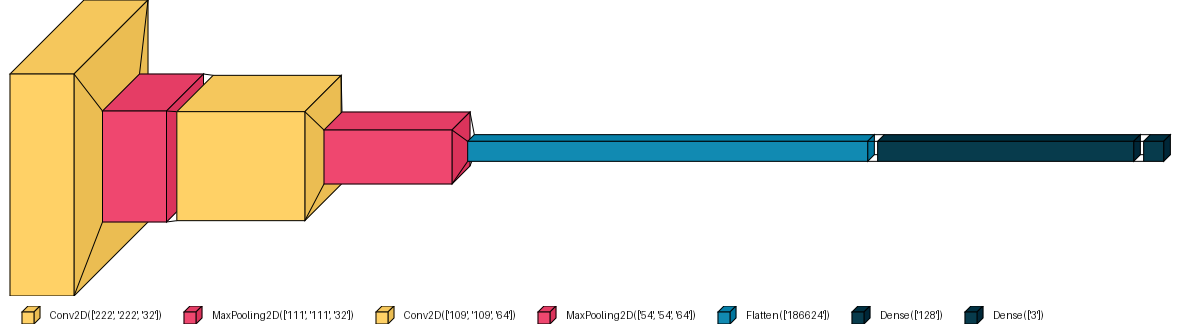

In [28]:
import visualkeras
visualkeras.layered_view(model, scale_xy=1, scale_z=2, legend=True, show_dimension=True)

In [13]:
# # Data augmentation to prevent overfitting and handle imbalance
# datagen = ImageDataGenerator(
#     featurewise_center=False,  # Do not center the dataset's mean
#     samplewise_center=False,  # Do not center each sample's mean
#     featurewise_std_normalization=False,  # Do not normalize the dataset's std
#     samplewise_std_normalization=False,  # Do not normalize each sample's std
#     zca_whitening=False,  # Do not apply ZCA whitening
#     rotation_range=30,  # Randomly rotate images up to 30 degrees
#     zoom_range=0.2,  # Randomly zoom into images
#     width_shift_range=0.1,  # Randomly shift images horizontally
#     height_shift_range=0.1,  # Randomly shift images vertically
#     horizontal_flip=True,  # Randomly flip images horizontally
#     vertical_flip=False  # Do not flip images vertically
# )

# # Fit the generator to the training data
# datagen.fit(x_train, seed=seed)

In [14]:
# Learning rate reduction on plateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=2,  # Number of epochs without improvement before reducing the learning rate
    verbose=1,  # Display a message when reducing the learning rate
    factor=0.3,  # Reduce learning rate by 70%
    min_lr=0.000001  # Minimum learning rate
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs without improvement before stopping
    restore_best_weights=True  # Restore the best weights after training stops
)

In [15]:
history = model.fit(x_train, y_train, batch_size = 64,
                    epochs = 50,
                    verbose = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[learning_rate_reduction, early_stopping]  # Callbacks
                   )

Epoch 1/50
4/4 [==============================] - 23s 5s/step - loss: 9.9144 - accuracy: 0.3825 - val_loss: 5.9395 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 19s 5s/step - loss: 3.2749 - accuracy: 0.2988 - val_loss: 1.3479 - val_accuracy: 0.3030 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 19s 5s/step - loss: 1.1954 - accuracy: 0.4024 - val_loss: 1.1521 - val_accuracy: 0.3939 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 19s 5s/step - loss: 1.0152 - accuracy: 0.4622 - val_loss: 0.9734 - val_accuracy: 0.4848 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 19s 5s/step - loss: 0.8072 - accuracy: 0.7888 - val_loss: 0.8626 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 6/50
4/4 [==============================] - 19s 5s/step - loss: 0.6420 - accuracy: 0.9084 - val_loss: 0.7208 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 7/50
4/4 [==============================] - 19s 5s/step - loss: 0.4671 - accuracy: 0.912

3/3 [==============================] - 1s 300ms/step


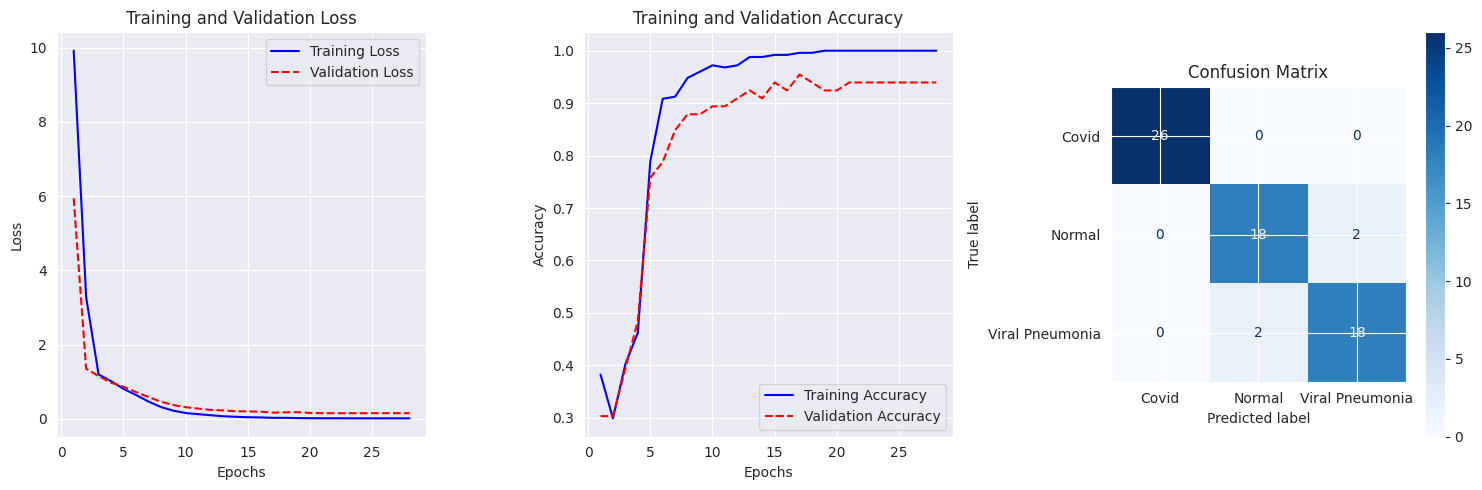

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       0.90      0.90      0.90        20
Viral Pneumonia       0.90      0.90      0.90        20

       accuracy                           0.94        66
      macro avg       0.93      0.93      0.93        66
   weighted avg       0.94      0.94      0.94        66



In [16]:
# Loss and Accuracy Graphs
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Predictions and Confusion Matrix
y_test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

plt.subplot(1, 3, 3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(y_test_labels, y_pred, target_names=labels))